# Feature selection ;)

In [267]:
import pickle
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sksurv.preprocessing import OneHotEncoder as SurvOneHotEncoder
from sksurv.util import Surv

from sksurv.column import encode_categorical
from sksurv.column import standardize
from sksurv.util import Surv

from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxnetSurvivalAnalysis


In [268]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

def evaluate_model_uno_c(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    return uno_concordance

In [269]:
pickle_file = 'data/COX_DATA_FULL_LIVING.pkl'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)

dataset.drop(['DIAG_KI', 'COD_KI'], axis=1, inplace=True)

In [270]:
dataset.shape

(52420, 56)

In [271]:
dataset['HBV_SUR_ANTIGEN'].value_counts()

N     50899
P       780
ND      741
Name: HBV_SUR_ANTIGEN, dtype: int64

In [272]:
yes_categorical=["PRE_TX_TXFUS", 
                "GENDER",
                "ON_DIALYSIS", 
                "ABO_MAT", 
                "ETHCAT", 
                "ETHCAT_DON",
                'HBV_CORE', 
                'DIAB',
                'HCV_SEROSTATUS',  
                'LIV_DON_TY',
                
                # 'HBV_SUR_ANTIGEN', # negative importance
                # "ABO", # negative importance
                # "ABO_DON", # negative importance
                # 'HBV_SUR_ANTIGEN_DON',  # negative importance
                # "GENDER_DON", # negative importance
                # "DIABETES_DON", # zero importance
                
            ]
yes_numerical = [   
                "KI_CREAT_PREOP",
                "SERUM_CREAT",
                "NPKID", 
                "AGE", 
                "HGT_CM_CALC", 
                "BMI_DON_CALC",
                "AGE_DON", 

                # HLA with some importance
                # 'DR1', 
                # 'BW6', 
                # 'BW4', 
                # 'RA1',
                # 'A2', 
                # 'DR53', 
                # 'C1', 
                # 'C2', 
                # 'A1',
                # 'RA2', 
                # 'DR51',
                # 'DR52', 
                # 'DQ2', 
                # 'RDR1',
                
                # 'BMIS', # negative importance
                # 'AMIS', # negative importance    
                # "WGT_KG_CALC", # negative importance
                # 'DR52_2', # zero importance
                # 'DR53_2', # zero importance
                # 'B2', # negative importance
                # "CREAT_TRR", # negative importance
                # 'DR2', # negative importance
                # 'RB1',# negative importance
                # 'B1', # negative importance
                # "BMI_CALC", # negative importance 
                # "WGT_KG_DON_CALC", # negative importance
                # "HGT_CM_DON_CALC", # negative importance
                # 'DQ1',# negative importance
                # 'RB2',# negative importance
                # 'RDR2',# negative importance
                ]

In [273]:
dataset[yes_categorical+yes_numerical].head()


,PRE_TX_TXFUS,GENDER,ON_DIALYSIS,ABO_MAT,ETHCAT,ETHCAT_DON,HBV_CORE,DIAB,HCV_SEROSTATUS,LIV_DON_TY,KI_CREAT_PREOP,SERUM_CREAT,NPKID,AGE,HGT_CM_CALC,BMI_DON_CALC,AGE_DON
__null_dask_index__,,,,,,,,,,,,,,,,,
28,N,F,Y,1.0,4,4.0,N,1.0,N,2.0,0.6,1.8,0.0,44.0,160.0,26.5714817,24.0
34,N,M,Y,2.0,4,4.0,N,1.0,N,7.0,0.9,4.3,0.0,33.0,177.0,21.5698674,40.0
42,N,F,N,1.0,1,1.0,N,1.0,N,2.0,0.9,0.6,0.0,67.0,157.5,27.1250543,46.0
47,N,M,Y,1.0,2,2.0,ND,5.0,N,2.0,0.9,3.3,0.0,56.0,175.0,28.0569769,18.0
52,Y,F,Y,2.0,1,1.0,N,1.0,N,4.0,0.8,1.3,0.0,20.0,152.4,28.5262249,26.0


In [274]:
dataset[yes_numerical].dtypes

KI_CREAT_PREOP    object
SERUM_CREAT       object
NPKID             object
AGE               object
HGT_CM_CALC       object
BMI_DON_CALC      object
AGE_DON           object
dtype: object

In [275]:
dataset[yes_numerical] = dataset[yes_numerical].astype(float)

dataset[yes_numerical].dtypes

KI_CREAT_PREOP    float64
SERUM_CREAT       float64
NPKID             float64
AGE               float64
HGT_CM_CALC       float64
BMI_DON_CALC      float64
AGE_DON           float64
dtype: object

In [276]:
dataset[yes_numerical].quantile([0.1, 0.90])

,KI_CREAT_PREOP,SERUM_CREAT,NPKID,AGE,HGT_CM_CALC,BMI_DON_CALC,AGE_DON
0.1,0.6,0.87,0.0,28.0,157.5,21.516204,26.0
0.9,1.1,2.90,0.0,65.0,185.4,32.610473,57.0


In [277]:
dataset.columns[dataset.isna().any()].tolist()

['DIABETES_DON', 'WGT_KG_CALC', 'RA2', 'BMI_CALC', 'RB2', 'RDR2', 'CREAT_TRR']

In [278]:
numeric_features = [x for x in yes_numerical if x != "PTIME" and x != "PSTATUS"]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore')) # maybe it's better to use not ignore
])

# Combine transformations for all features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, yes_numerical),
        ('cat', categorical_transformer, yes_categorical)
    ]
)

# Set up the final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Apply preprocessing to X
X = pipeline.fit_transform(dataset[yes_categorical + yes_numerical])

# For calculating feature importance
# categorical_x = encode_categorical(dataset[yes_categorical])
# numerical_x = standardize(dataset[yes_numerical])
# X = pd.concat([numerical_x, categorical_x], axis=1)

survival_time = dataset["PTIME"].astype(np.float64)
event = dataset["PSTATUS"].astype(float).astype(bool)

y = Surv.from_arrays(event, survival_time, "Status", "Days")

In [279]:
# save the preprocessor
with open('pickle/pipeline_coxnet_living.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [280]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y["Status"], random_state=42)

In [281]:
from tqdm._tqdm_notebook import tqdm
import numpy as np

best_params = None
highest_cindex=0

lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

cox = CoxnetSurvivalAnalysis(l1_ratio=0.9, max_iter=1000)
cox.fit(X_train, y_train)

estimated_alphas = cox.alphas_
l1_ratios = [0.9]

cox_grid=CoxnetSurvivalAnalysis()

pbar = tqdm(total = len(estimated_alphas)*len(l1_ratios), desc='Hyperparameter Tuning')

for ratio in l1_ratios:
    for alpha in estimated_alphas:
        cox_grid.set_params(l1_ratio=ratio, alphas=[alpha])

        cox_grid.fit(X_train, y_train)
        uno_score = evaluate_model_uno_c(cox_grid, X_test, y_test, y_train, times)

        uno = float(uno_score[0])
        if uno > highest_cindex:
            highest_cindex = uno
            best_params = (ratio, alpha)
            best_rsf_model = cox_grid

        # Update the progress bar
        pbar.update()

Hyperparameter Tuning:   0%|          | 0/74 [00:00<?, ?it/s]

/var/folders/c7/7_0s689j2m99wkwqx2b0skvm0000gn/T/ipykernel_62851/2652288410.py:24: UserWarning: all coefficients are zero, consider decreasing alpha.
  cox_grid.fit(X_train, y_train)


In [282]:
highest_cindex # start: 0.7240850453830636 // 0.7174403712287055

0.7289539852313759

In [283]:
best_params

(0.9, 0.0005931413744179138)

In [284]:
coxnet_pred = CoxnetSurvivalAnalysis(l1_ratio=best_params[0],alphas=[best_params[1]], fit_baseline_model=True)
coxnet_pred.fit(X_train, y_train)

CoxnetSurvivalAnalysis(alphas=[0.0005931413744179138], fit_baseline_model=True,
                       l1_ratio=0.9)

In [285]:
lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

evaluate_model_uno_c(coxnet_pred, X_test, y_test, y_train, times)

(0.7289539852313759, 13744856, 5185339, 0, 3728)

Interesting: the use of scikit-learn transformers alone increases model's c-index from 0.717 to o.733

With HLA: 0.7329622178077422

Without HLA: 0.7325947154087512

Conclusion: HLA has little to no correlation with long-term survival! Probably because it was already accounted for before the transplantation.

In [286]:
import pickle

pickle_file = 'pickle/COXNET_LIVING_MODEL.pickle'

with open(pickle_file, 'wb') as f:
    pickle.dump(coxnet_pred, f)


In [292]:
# keep it commented in order to avoid putting wrong model into the application
# run it only if you are sure that the model and the pipeline are good

# ! bash export_models.sh

Copying coxnet living model and pipeline...
Copying coxnet deceased model and pipeline...
Copying model descriptions...


In [288]:
X_train.shape

(41936, 55)

In [289]:
res = coxnet_pred.predict_survival_function(X_test)

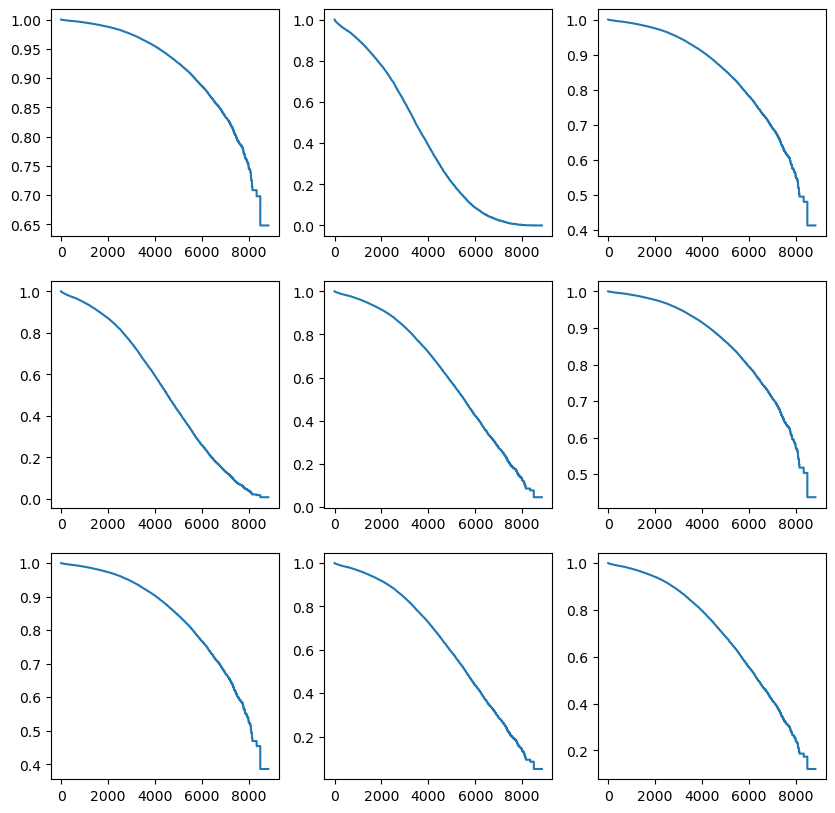

In [290]:
import matplotlib.pyplot as plt

number = 9

# Plot the step function
# plt.step(res[number].x, res[number].y)

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# Flatten the axs array to make it easier to iterate over
axs = axs.flatten()

for i, (ax, sf) in enumerate(zip(axs, res[:number])):
    ax.step(sf.x, sf.y)

plt.show()


In [ ]:
from sklearn.inspection import permutation_importance

# uncoment if you want to calculate permutation importance (data must not be processed by pipeline)
# result = permutation_importance(coxnet_pred, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)

In [ ]:
pd.set_option('display.max_rows', None)

# columns = numeric_features + categorical_features

importances_df = pd.DataFrame(result.importances_mean, index=X_test.columns)
importances_df.columns = ['Importance']
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print out feature importances
print(importances_df)